<a href="https://colab.research.google.com/github/nakamura41/emotion_detection_notebooks/blob/master/EmoInt_Emotion_Analysis_ConvNet_Threshold_0_33.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive

In [0]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import urllib.request
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tempfile import gettempdir
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

Using TensorFlow backend.


1.12.0


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download google drive file
def download_drive_file(drive_directory, filename):
  list_file_query = "title='{}' and trashed=false".format(drive_directory)
  file_list = drive.ListFile({'q': list_file_query}).GetList()

  if len(file_list) > 0:
    directory_id = file_list[0]['id']

    list_file_query = "'{}' in parents".format(directory_id)

    file_list = drive.ListFile({'q': list_file_query}).GetList()
    
    file_id = None
    for file1 in file_list:
      if file1['title'] == filename:
        print("downloading file {}".format(file1['title']))
        file1.GetContentFile(file1['title'])

In [0]:
# upload google drive file
def upload_drive_file(drive_directory, filename):
  list_file_query = "title='{}' and trashed=false".format(drive_directory)
  file_list = drive.ListFile({'q': list_file_query}).GetList()

  if len(file_list) > 0:
    directory_id = file_list[0]['id']
    file = drive.CreateFile({
        'title': filename, 
        "parents": [{"kind": "drive#fileLink","id": directory_id}]
    })
    file.SetContentFile(filename)
    file.Upload()

In [0]:
def save_numpy_array(numpy_array, filename):
  np.save(filename, numpy_array)
  
def save_n_upload_numpy_array(numpy_array, drive_directory, filename):
  save_numpy_array(numpy_array, filename)
  upload_drive_file(drive_directory, filename)

In [0]:
class EmoIntDataset(object):
  BASE_URL = "http://saifmohammad.com/WebDocs/"
  TRAIN_URI = "EmoInt%20Train%20Data/{}-ratings-0to1.train.txt"
  TEST_URI = "EmoInt%20Test%20Gold%20Data/{}-ratings-0to1.test.gold.txt"
  EMOTION_CLASSES = ["anger", "fear", "joy", "sadness"]
  
  THRESHOLD = 0.33
  
  def __load_data_per_class(self, url, threshold=0):
    resource = urllib.request.urlopen(url)
    np_array = np.asarray([line.split('\t') for line in [line.strip() for line in resource.read().decode('utf-8').splitlines()]])
    df = pd.DataFrame(np_array, columns=["id", "text", "emotion", "emotion_level"])
    df['emotion_level'] = df['emotion_level'].astype(float)
    df = df.query('emotion_level>' + str(threshold))
    return df[["text", "emotion"]]
  
  def load_data(self, set_threshold=False):
    train_data = None
    test_data = None
    
    for emotion in self.EMOTION_CLASSES:
      # load train dataset
      train_df = self.__load_data_per_class(self.BASE_URL + self.TRAIN_URI.format(emotion), threshold=(self.THRESHOLD if set_threshold else 0))
      
      # load test dataset
      test_df = self.__load_data_per_class(self.BASE_URL + self.TEST_URI.format(emotion), threshold=(self.THRESHOLD if set_threshold else 0))
      
      train_data = (train_df if train_data is None else train_data.append(train_df))
      test_data = (test_df if test_data is None else test_data.append(test_df))
      
    return train_data, test_data

In [0]:
emo_int_dataset = EmoIntDataset()
train_data, test_data = emo_int_dataset.load_data(set_threshold=True)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=200, stratify=train_data.emotion)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(2610, 2)
(291, 2)
(2508, 2)


In [0]:
emotions = train_data.emotion.unique()
dic = dict()
labels = []
for i, emotion in enumerate(emotions):
    dic[emotion]=i
    labels.append(emotion)
print(dic)
print(labels)

{'fear': 0, 'anger': 1, 'sadness': 2, 'joy': 3}
['fear', 'anger', 'sadness', 'joy']


In [0]:
NUM_WORDS=20000
texts = train_data.text
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid = tokenizer.texts_to_sequences(valid_data.text)
sequences_test = tokenizer.texts_to_sequences(test_data.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8672 unique tokens.


In [0]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid, maxlen=X_train.shape[1])
X_test = pad_sequences(sequences_test, maxlen=X_train.shape[1])

y_train = to_categorical(np.asarray(train_data.emotion.apply(lambda x:dic[x])))
y_val = to_categorical(np.asarray(valid_data.emotion.apply(lambda x:dic[x])))
y_test = to_categorical(np.asarray(test_data.emotion.apply(lambda x:dic[x])))

print('Shape of X train, validation and test tensor:', X_train.shape, X_val.shape, X_test.shape)
print('Shape of label train, validation and test tensor:', y_train.shape, y_val.shape, y_test.shape)

Shape of X train, validation and test tensor: (2610, 33) (291, 33) (2508, 33)
Shape of label train, validation and test tensor: (2610, 4) (291, 4) (2508, 4)


In [0]:
download_drive_file("Datasets", "GoogleNews-vectors-negative300.bin.gz")

downloading file GoogleNews-vectors-negative300.bin.gz


In [0]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

EMBEDDING_DIM=300
vocabulary_size = min(len(word_index)+1, NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)

## Reload embedding layer and training dataset

In [0]:
file_embedded_matrix = "emoint_embedded_matrix_word2vec.npy"
download_drive_file("Colab Notebooks", file_embedded_matrix)
embedding_matrix = np.load(file_embedded_matrix)
print("embedding matrix shape:", embedding_matrix.shape)

downloading file emoint_embedded_matrix_word2vec.npy
downloading file emoint_embedded_matrix_word2vec.npy
embedding matrix shape: (8673, 300)


In [0]:
download_drive_file("Colab Notebooks", "emoint_X_train.npy")
download_drive_file("Colab Notebooks", "emoint_X_val.npy")
download_drive_file("Colab Notebooks", "emoint_X_test.npy")

download_drive_file("Colab Notebooks", "emoint_y_train.npy")
download_drive_file("Colab Notebooks", "emoint_y_val.npy")
download_drive_file("Colab Notebooks", "emoint_y_test.npy")

X_train = np.load("emoint_X_train.npy")
X_val = np.load("emoint_X_val.npy")
X_test = np.load("emoint_X_test.npy")

y_train = np.load("emoint_y_train.npy")
y_val = np.load("emoint_y_val.npy")
y_test = np.load("emoint_y_test.npy")

downloading file emoint_X_train.npy
downloading file emoint_X_train.npy
downloading file emoint_X_train.npy
downloading file emoint_X_train.npy
downloading file emoint_X_val.npy
downloading file emoint_X_val.npy
downloading file emoint_X_val.npy
downloading file emoint_X_val.npy
downloading file emoint_X_test.npy
downloading file emoint_X_test.npy
downloading file emoint_X_test.npy
downloading file emoint_X_test.npy
downloading file emoint_y_train.npy
downloading file emoint_y_train.npy
downloading file emoint_y_train.npy
downloading file emoint_y_train.npy
downloading file emoint_y_val.npy
downloading file emoint_y_val.npy
downloading file emoint_y_val.npy
downloading file emoint_y_val.npy
downloading file emoint_y_test.npy
downloading file emoint_y_test.npy
downloading file emoint_y_test.npy
downloading file emoint_y_test.npy


In [0]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate, LSTM
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.models import Model
from keras import regularizers
sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop_rate = 0.5
vocabulary_size = 8673
EMBEDDING_DIM=300

print(sequence_length)

inputs = Input(shape=(sequence_length,), name='input_1')
embedding_layer = Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=sequence_length, trainable=True, name='embedding')
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length, EMBEDDING_DIM, 1), name='reshape_1')(embedding)

conv_1 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_1')(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_2')(reshape)
conv_3 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_3')(reshape)

maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=1, name='maxpool_1')(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=1, name='maxpool_2')(conv_2)
maxpool_3 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=1, name='maxpool_3')(conv_3)

merged_tensor = concatenate([maxpool_1, maxpool_2, maxpool_3], axis=1, name='concatenate_1')
flatten = Flatten()(merged_tensor)
dropout = Dropout(drop_rate, name='dropout_1')(flatten)
output = Dense(units=4, activation='softmax',kernel_regularizer=regularizers.l2(0.01), name='dense_1')(dropout)

model = None 

# this creates a model that includes
model = Model(inputs, output)

model.summary()

33
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 300)      2601900     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 33, 300, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 31, 1, 100)   90100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv_2 

In [0]:
!rm -r tmp
!mkdir tmp
!ls -lA

total 1801576
-rw-r--r-- 1 root root       2530 Dec 17 03:53 adc.json
drwxr-xr-x 1 root root       4096 Dec 17 03:53 .config
-rw-r--r-- 1 root root   55482024 Dec 17 07:15 emoint_bidirectional_lstm_model.h5
-rw-r--r-- 1 root root   27745664 Dec 17 07:15 emoint_bidirectional_lstm_weights.h5
-rw-r--r-- 1 root root   20815328 Dec 17 07:31 emoint_embedded_matrix_word2vec.npy
-rw-r--r-- 1 root root   38158376 Dec 17 07:00 emoint_lstm_model.h5
-rw-r--r-- 1 root root   19083168 Dec 17 07:00 emoint_lstm_weights.h5
-rw-r--r-- 1 root root   23748760 Dec 17 03:57 emoint_model.h5
-rw-r--r-- 1 root root   11880960 Dec 17 03:57 emoint_weights.h5
-rw-r--r-- 1 root root     331184 Dec 17 07:31 emoint_X_test.npy
-rw-r--r-- 1 root root     344648 Dec 17 07:31 emoint_X_train.npy
-rw-r--r-- 1 root root      38540 Dec 17 07:31 emoint_X_val.npy
-rw-r--r-- 1 root root      40256 Dec 17 07:31 emoint_y_test.npy
-rw-r--r-- 1 root root      41888 Dec 17 07:31 emoint_y_train.npy
-rw-r--r-- 1 root root       4784 

## Two-steps training

In [0]:
adam = Adam(lr=1e-3, decay=0.0)
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc'])

filepath="tmp/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
callbacks = [early_stopping, model_checkpoint]

history = model.fit(X_train, y_train, batch_size=1000, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)  # starts training

Train on 2610 samples, validate on 291 samples
Epoch 1/100
2610/2610 [==============================] - 5s 2ms/step - loss: 1.6730 - acc: 0.2801 - val_loss: 1.6613 - val_acc: 0.3574

Epoch 00001: val_acc improved from -inf to 0.35739, saving model to tmp/weights-01-0.36.hdf5
Epoch 2/100
2610/2610 [==============================] - 0s 139us/step - loss: 1.5620 - acc: 0.4195 - val_loss: 1.5330 - val_acc: 0.3608

Epoch 00002: val_acc improved from 0.35739 to 0.36082, saving model to tmp/weights-02-0.36.hdf5
Epoch 3/100
2610/2610 [==============================] - 0s 131us/step - loss: 1.3372 - acc: 0.5644 - val_loss: 1.3317 - val_acc: 0.5464

Epoch 00003: val_acc improved from 0.36082 to 0.54639, saving model to tmp/weights-03-0.55.hdf5
Epoch 4/100
2610/2610 [==============================] - 0s 135us/step - loss: 1.1846 - acc: 0.7034 - val_loss: 1.2336 - val_acc: 0.6529

Epoch 00004: val_acc improved from 0.54639 to 0.65292, saving model to tmp/weights-04-0.65.hdf5
Epoch 5/100
2610/2610 

In [0]:
X_train_combined = np.concatenate((X_train, X_val))
y_train_combined = np.concatenate((y_train, y_val))

history = model.fit(X_train_combined, y_train_combined, batch_size=1000, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)  # starts training

Train on 2901 samples, validate on 291 samples
Epoch 1/100
2901/2901 [==============================] - 1s 405us/step - loss: 0.1872 - acc: 0.9790 - val_loss: 0.3515 - val_acc: 0.9141

Epoch 00001: val_acc did not improve from 0.91753
Epoch 2/100
2901/2901 [==============================] - 0s 136us/step - loss: 0.1842 - acc: 0.9804 - val_loss: 0.3160 - val_acc: 0.9278

Epoch 00002: val_acc improved from 0.91753 to 0.92784, saving model to tmp/weights-02-0.93.hdf5
Epoch 3/100
2901/2901 [==============================] - 0s 130us/step - loss: 0.1793 - acc: 0.9821 - val_loss: 0.3009 - val_acc: 0.9347

Epoch 00003: val_acc improved from 0.92784 to 0.93471, saving model to tmp/weights-03-0.93.hdf5
Epoch 4/100
2901/2901 [==============================] - 0s 132us/step - loss: 0.1754 - acc: 0.9841 - val_loss: 0.2931 - val_acc: 0.9416

Epoch 00004: val_acc improved from 0.93471 to 0.94158, saving model to tmp/weights-04-0.94.hdf5
Epoch 5/100
2901/2901 [==============================] - 0s 133

In [0]:
model_path = 'emoint_convnet_model.h5'
weight_path = 'emoint_convnet_weights.h5'

model.save(model_path)
model.save_weights(weight_path)

In [0]:
!ls -lah

total 1.8G
drwxr-xr-x 1 root root 4.0K Dec 17 07:34 .
drwxr-xr-x 1 root root 4.0K Dec 17 03:52 ..
-rw-r--r-- 1 root root 2.5K Dec 17 03:53 adc.json
drwxr-xr-x 1 root root 4.0K Dec 17 03:53 .config
-rw-r--r-- 1 root root  53M Dec 17 07:15 emoint_bidirectional_lstm_model.h5
-rw-r--r-- 1 root root  27M Dec 17 07:15 emoint_bidirectional_lstm_weights.h5
-rw-r--r-- 1 root root  23M Dec 17 07:34 emoint_convnet_model.h5
-rw-r--r-- 1 root root  12M Dec 17 07:34 emoint_convnet_weights.h5
-rw-r--r-- 1 root root  20M Dec 17 07:31 emoint_embedded_matrix_word2vec.npy
-rw-r--r-- 1 root root  37M Dec 17 07:00 emoint_lstm_model.h5
-rw-r--r-- 1 root root  19M Dec 17 07:00 emoint_lstm_weights.h5
-rw-r--r-- 1 root root  23M Dec 17 03:57 emoint_model.h5
-rw-r--r-- 1 root root  12M Dec 17 03:57 emoint_weights.h5
-rw-r--r-- 1 root root 324K Dec 17 07:31 emoint_X_test.npy
-rw-r--r-- 1 root root 337K Dec 17 07:31 emoint_X_train.npy
-rw-r--r-- 1 root root  38K Dec 17 07:31 emoint_X_val.npy
-rw-r--r-- 1 root roo

In [0]:
upload_drive_file("Colab Notebooks", model_path)
upload_drive_file("Colab Notebooks", weight_path)

In [0]:
sequences_test=tokenizer.texts_to_sequences(test_data.text)
X_test = pad_sequences(sequences_test, maxlen=X_test.shape[1])
y_pred = model.predict(X_test)

In [0]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
y_pred_original = [labels[val] for val in np.argmax(y_pred, axis=1).squeeze()]
y_test_original = np.asarray(test_data.emotion)

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [0]:
cf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=labels)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,fear,anger,sadness,joy
fear,647,49,75,18
anger,43,553,33,14
sadness,47,40,437,9
joy,22,13,14,494


Figure(288x216)


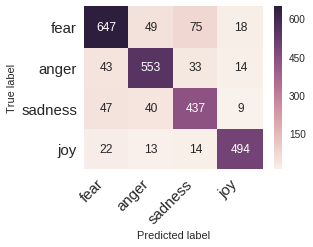

In [0]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [0]:
test_accuracy = accuracy_score(y_test_original, y_pred_original)
print("test accuracy:", test_accuracy)

test accuracy: 0.8496810207336523


### Performance score for each classes

In [0]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,f1-score,precision,recall,support
fear,0.8521,0.8443,0.8600,643
anger,0.8359,0.8524,0.8200,789
sadness,0.9165,0.9234,0.9098,543
joy,0.8004,0.7818,0.8199,533


### Performance score using micro average

In [0]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.8497,0.8497,0.8497,None


### Performance score using macro average

In [0]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.8512,0.8505,0.8524,None


### Performance score using weighted average

In [0]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.85,0.8507,0.8497,None


In [0]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(y_test_original, y_pred_original, labels=labels)
print("kappa:", kappa_score)

kappa: 0.7980355417255142
